In [80]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [81]:
class Oven:
    def __init__(self, start_temp : int, working_temps : list[int], operations : list[str]) -> None:
        self.start_temp = start_temp
        self.working_temps = working_temps
        self.operations = operations

class Operation:
    def __init__(self, name : str, timing : int) -> None:
        self.name = name
        self.timing = timing

class Series:
    def __init__(self, temperature : int, operations : list[Operation]) -> None:
        self.temperature = temperature
        self.operations = [Operation(**json.loads(json.dumps(op))) for op in operations]

class DayData:
    def __init__(self, ovens : list[Oven], series : list[Series]) -> None:
        self.ovens = [Oven(**json.loads(json.dumps(oven))) for oven in ovens]
        self.series = [Series(**json.loads(json.dumps(ser))) for ser in series]

Сериализация входного json-файла

In [82]:
path = './train/day-9.json'
dayData = DayData(**json.loads(open(path).read()))

Предварительное распределение по печкам

<image src="./etc/Example.png"/>

In [83]:
# Поиск наименее загруженной печи в заданном потоке
def find_min(keys : list, src : dict) -> Oven:
    minv = 10e9
    min_obj = None
    for key in keys:
        if len(src[key]) < minv:
            minv = len(src[key])
            min_obj = key
    
    return min_obj



ovens = dayData.ovens
series = dayData.series

# Серии, не распределеные по печам
wasted_series = []

# Предварительный поток печей (Аналогично примеру в .xlxm файле. Ключ словаря - объект печки)
ovens_stream : dict[Oven, list[Series]] = {
    oven : [] for oven in ovens
}

for ser in series:
    # Поиск печек, поддерживающих операции для данной серии
    same_opers_ovens = [oven for oven in ovens if \
                        len(set(oven.operations) & set([op.name for op in ser.operations])) == (len(set([op.name for op in ser.operations])) - 1)]
    

    if len(same_opers_ovens):
        # С одинаковой начальной темп.
        same_temps_ovens = [oven for oven in same_opers_ovens if oven.start_temp == ser.temperature]
        if len(same_temps_ovens):
            # Наименее нагруженная печка
            min_filled_oven = find_min(same_temps_ovens, ovens_stream)
            ovens_stream[min_filled_oven].append(ser)
        else:
            min_filled_oven = find_min(same_opers_ovens, ovens_stream)
            ovens_stream[min_filled_oven].append(ser)
    else:
        wasted_series.append(ser)

def pretty_print(src):
    return [((key.start_temp, key.operations), [(ser.temperature, [(op.name, op.timing) for op in ser.operations])
      for ser in src[key]]) for key in src.keys() if 'prokat' in key.operations]

Оптимизация потока серий в каждой печи

In [84]:
# Сортировка серий в каждой печке по разнице между нач.темп и темп. серии
for oven in ovens_stream.keys():
    ovens_stream[oven].sort(key=lambda s: abs(s.temperature - oven.start_temp))

In [85]:
class OperationDto:
    def __init__(self, type, abs_start, abs_end) -> None:
        self.type = type
        self.abs_start = abs_start
        self.abs_end = abs_end

class SeriesDto:
    def __init__(self, operations : list[OperationDto]) -> None:
        self.operations = operations

In [86]:
def optimize_with_timing(oven_temp : int, series : list[Series]) -> list[SeriesDto]:
    curr_time = 0
    TIME_ELAPSED = 1440
    dto_series : list[SeriesDto] = []
    for ser in series:
        to_upload = True

        opers_temp : list[OperationDto] = []
        # Вручную первую операцию
        if curr_time + ser.operations[0].timing <=TIME_ELAPSED:
            opers_temp.append(OperationDto(ser.operations[0].name, curr_time, curr_time + ser.operations[0].timing))
            curr_time += ser.operations[0].timing

        # +2 часа при разных темпах
        if ser.temperature != oven_temp:
            curr_time += 120
            oven_temp = ser.temperature

        for i in range(1, len(ser.operations)):
            op = ser.operations[i]
            # Проверка на границу дня
            if curr_time + op.timing > TIME_ELAPSED:
                to_upload = False
                break
            # Две одинаковые операции - +2 часа на подогрев
            if ser.operations[i - 1].name == op.name:
                if curr_time + 120 >= TIME_ELAPSED:
                    to_upload = False
                    break 
                opers_temp.append(OperationDto('progrev goev', curr_time, curr_time + 120))
                curr_time += 120
        
            opers_temp.append(OperationDto(op.name, curr_time, curr_time + op.timing))
            curr_time += op.timing

        if to_upload:
            dto_series.append(SeriesDto(opers_temp))
    return dto_series

In [87]:
optimized_ovens_stream : dict[Oven, list[SeriesDto]]= {
    oven : [] for oven in ovens_stream.keys()
}
# Инициализация результирующего потока
for oven in ovens_stream.keys():
    optimized_ovens_stream[oven] = optimize_with_timing(oven.start_temp, ovens_stream[oven])

Вывод в файл

In [88]:
oven_cnt = 1
with open('./etc/out.txt', 'w') as w:
    for oven in optimized_ovens_stream.keys():
        series_cnt = 1
        w.write(
            f'###Oven N:{oven_cnt}; {oven.start_temp, oven.operations}###\n')
        for ser in optimized_ovens_stream[oven]:
            w.write(f'    Series {series_cnt} of {oven_cnt} oven\n')
            for op in ser.operations:
                w.write(f'        {op.type, op.abs_start, op.abs_end}\n')
            series_cnt += 1
        oven_cnt += 1

In [89]:
workload = sum([len(optimized_ovens_stream[oven]) for oven in optimized_ovens_stream.keys()])
print(f'Workload percent {(workload / len(dayData.series) * 100)}%')

Workload percent 68.84808013355592%


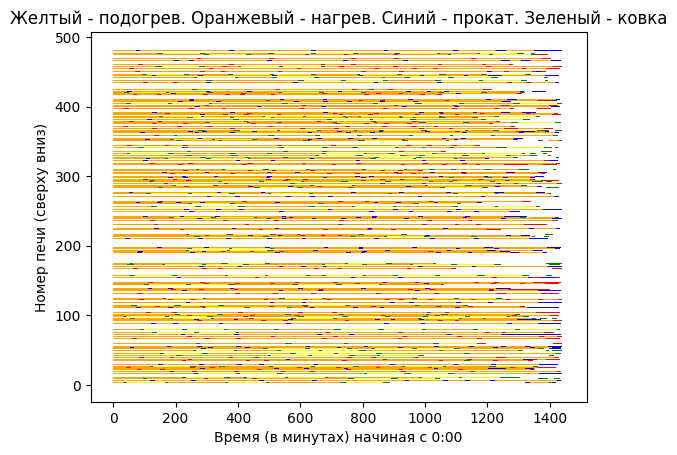

In [90]:
def map_color(type :str):
    if type == 'nagrev':
        return 'orange'
    if type == 'kovka':
        return 'green'
    if type == 'otzhig':
        return 'red'
    if type == 'progrev goev':
        return 'yellow'
    if type == 'prokat':
        return 'blue'
    
fig, ax = plt.subplots()
ax.plot([0, 1440], [0, len(optimized_ovens_stream.keys())])
ax.get_lines()[0].remove()

cnt = len(optimized_ovens_stream.keys())
for oven in optimized_ovens_stream.keys():
    for ser in optimized_ovens_stream[oven]:
        for op in ser.operations:
            ax.add_patch(Rectangle( (op.abs_start, cnt), op.abs_end - op.abs_start, 0.8, facecolor=map_color(op.type)))
    cnt -= 1

ax.set_xlabel('Время (в минутах) начиная с 0:00')
ax.set_ylabel('Номер печи (сверху вниз)')

ax.set_title('Желтый - подогрев. Оранжевый - нагрев. Синий - прокат. Зеленый - ковка')
plt.show()

# Здесь есть нюанс с изменением темпы. печи в зависимости от серии
# Пропуски между соседними состояними - это состояние нагревания/охлаждения печи под серию